In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt



## The Data

This week, we consider a dataset generated from text data.

The original dataset can be found here: https://www.kaggle.com/datasets/kingburrito666/cannabis-strains. It consists of user reviews of different strains of cannabis. Users rated their experience with the cannabis strain on a scale of 1 to 5. They also selected words from a long list to describe the Effects and the Flavor of the cannabis.

In the dataset linked above, each row is one strain of cannabis. The average rating of all testers is reported, as well as the most commonly used words for the effect and flavor.

Some data cleaning has been performed for you: The Effect and Flavor columns have been converted to dummy variables indicating if the particular word was used for the particular strain.

This cleaned data can be found at: https://www.dropbox.com/s/s2a1uoiegitupjc/cannabis_full.csv

Our goal will be to fit models that identify the Sativa types from the Indica types, and then to fit models that also distinguish the Hybrid types.

IMPORTANT: In this assignment, you do not need to consider different feature sets. Normally, this would be a good thing to try - but for this homework, simply include all the predictors for every model.

In [3]:
cannabis_df = pd.read_csv('cannabis_full.csv')

cannabis_df.dropna(inplace=True)
cannabis_df.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Part One: Binary Classification

Create a dataset that is limited only to the Sativa and Indica type cannabis strains.

This section asks you to create a final best model for each of the four new model types studied this week: LDA, QDA, SVC, and SVM. For SVM, you may limit yourself to only the polynomial kernel.

For each, you should:

Choose a metric you will use to select your model, and briefly justify your choice. (Hint: There is no specific target category here, so this should not be a metric that only prioritizes one category.)

Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

Report the (cross-validated!) metric.

Fit the final model.

Output a confusion matrix.

In [4]:
filtered_df = cannabis_df[(cannabis_df['Type']== "sativa") | (cannabis_df['Type']== "indica")]
filtered_df.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,303-Og,indica,4.2,"Relaxed,Happy,Euphoric,Uplifted,Giggly","Citrus,Pungent,Earthy",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3D-Cbd,sativa,4.6,"Uplifted,Focused,Happy,Talkative,Relaxed","Earthy,Woody,Flowery",0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3X-Crazy,indica,4.4,"Relaxed,Tingly,Happy,Euphoric,Uplifted","Earthy,Grape,Sweet",0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,5Th-Element,indica,4.4,"Relaxed,Focused,Euphoric,Uplifted,Aroused","Earthy,Woody,Pine",0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Q1: LDA

In [5]:
X = filtered_df.drop(columns=["Type", "Strain", "Effects", "Flavor"])
y = filtered_df['Type']

X = pd.get_dummies(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(filtered_df['Type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify=y)

In [6]:
import warnings
warnings.filterwarnings("ignore")

lda_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])

lda_model = lda_pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(lda_model, X_train, y_train, cv=5, scoring="accuracy")

param_grid = {
    'lda__solver': ['svd', 'lsqr', 'eigen'],
    'lda__shrinkage': [None, 'auto'],
}

gscv = GridSearchCV(lda_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

gscv.fit(X_train, y_train)

best_lda = gscv.best_estimator_
lda_y_pred = best_lda.predict(X_test)

print("Best Parameters:", gscv.best_params_)

print("Best Cross-Validated Accuracy:", gscv.best_score_)
print("Confusion Matrix:", confusion_matrix(y_test, lda_y_pred))
print("Classification Report:", classification_report(y_test, lda_y_pred))

Best Parameters: {'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}
Best Cross-Validated Accuracy: 0.8664671482628139
Confusion Matrix: [[121  11]
 [ 22  60]]
Classification Report:               precision    recall  f1-score   support

      indica       0.85      0.92      0.88       132
      sativa       0.85      0.73      0.78        82

    accuracy                           0.85       214
   macro avg       0.85      0.82      0.83       214
weighted avg       0.85      0.85      0.84       214

Best Parameters: {'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}
Best Cross-Validated Accuracy: 0.8664671482628139
Confusion Matrix: [[121  11]
 [ 22  60]]
Classification Report:               precision    recall  f1-score   support

      indica       0.85      0.92      0.88       132
      sativa       0.85      0.73      0.78        82

    accuracy                           0.85       214
   macro avg       0.85      0.82      0.83       214
weighted avg       0.85      0.85      

## Q2: QDA

In [7]:
qda_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('qda', QuadraticDiscriminantAnalysis())
])

param_grid = {
    'qda__reg_param': [0.0, 0.1, 0.2, 0.5, 1.0],
}

qda_gscv = GridSearchCV(qda_pipeline, param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
qda_gscv.fit(X_train, y_train)

print("Best Parameters:", qda_gscv.best_params_)
print("Best Cross-Validated Accuracy:", qda_gscv.best_score_)

best_qda = qda_gscv.best_estimator_
qda_y_pred = best_qda.predict(X_test)

print("Confusion Matrix:", confusion_matrix(y_test, qda_y_pred))
print("Classification Report:", classification_report(y_test, qda_y_pred))

Best Parameters: {'qda__reg_param': 1.0}
Best Cross-Validated Accuracy: 0.8652906776745786
Confusion Matrix: [[120  12]
 [ 19  63]]
Classification Report:               precision    recall  f1-score   support

      indica       0.86      0.91      0.89       132
      sativa       0.84      0.77      0.80        82

    accuracy                           0.86       214
   macro avg       0.85      0.84      0.84       214
weighted avg       0.85      0.86      0.85       214

Best Parameters: {'qda__reg_param': 1.0}
Best Cross-Validated Accuracy: 0.8652906776745786
Confusion Matrix: [[120  12]
 [ 19  63]]
Classification Report:               precision    recall  f1-score   support

      indica       0.86      0.91      0.89       132
      sativa       0.84      0.77      0.80        82

    accuracy                           0.86       214
   macro avg       0.85      0.84      0.84       214
weighted avg       0.85      0.86      0.85       214



## Question 3 SVC

In [8]:
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC())
])

param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__max_iter': [1000, 5000],
}

svc_gscv = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

svc_gscv.fit(X_train, y_train)

print("Best Parameters:", svc_gscv.best_params_)
print("Best Cross-Validated Accuracy:", svc_gscv.best_score_)

svc_model = svc_gscv.best_estimator_
svc_y_pred = svc_gscv.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, svc_y_pred))
print("Classification Report:\n", classification_report(y_test, svc_y_pred))

Best Parameters: {'svc__C': 1, 'svc__max_iter': 1000}
Best Cross-Validated Accuracy: 0.8500997592019264
Confusion Matrix:
 [[120  12]
 [ 22  60]]
Classification Report:
               precision    recall  f1-score   support

      indica       0.85      0.91      0.88       132
      sativa       0.83      0.73      0.78        82

    accuracy                           0.84       214
   macro avg       0.84      0.82      0.83       214
weighted avg       0.84      0.84      0.84       214

Best Parameters: {'svc__C': 1, 'svc__max_iter': 1000}
Best Cross-Validated Accuracy: 0.8500997592019264
Confusion Matrix:
 [[120  12]
 [ 22  60]]
Classification Report:
               precision    recall  f1-score   support

      indica       0.85      0.91      0.88       132
      sativa       0.83      0.73      0.78        82

    accuracy                           0.84       214
   macro avg       0.84      0.82      0.83       214
weighted avg       0.84      0.84      0.84       214



## Question 4 SVM

In [9]:
svm_pipeline = Pipeline(
[
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='poly'))
])

param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__degree': [2, 3, 4],
    'svc__gamma': ['scale', 'auto']
}

svm_gscv = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

svm_gscv.fit(X_train, y_train)

print("Best Parameters:", svm_gscv.best_params_)
print("Best Cross-Validated Accuracy:", svm_gscv.best_score_)

svm_model = svm_gscv.best_estimator_
svm_y_pred = svm_model.predict(X_test)

print("Confusion Matrix:", confusion_matrix(y_test, svm_y_pred))
print("Classification Report:", classification_report(y_test, svm_y_pred))

Best Parameters: {'svc__C': 10, 'svc__degree': 3, 'svc__gamma': 'scale'}
Best Cross-Validated Accuracy: 0.8371861025111798
Confusion Matrix: [[121  11]
 [ 27  55]]
Classification Report:               precision    recall  f1-score   support

      indica       0.82      0.92      0.86       132
      sativa       0.83      0.67      0.74        82

    accuracy                           0.82       214
   macro avg       0.83      0.79      0.80       214
weighted avg       0.82      0.82      0.82       214

Best Parameters: {'svc__C': 10, 'svc__degree': 3, 'svc__gamma': 'scale'}
Best Cross-Validated Accuracy: 0.8371861025111798
Confusion Matrix: [[121  11]
 [ 27  55]]
Classification Report:               precision    recall  f1-score   support

      indica       0.82      0.92      0.86       132
      sativa       0.83      0.67      0.74        82

    accuracy                           0.82       214
   macro avg       0.83      0.79      0.80       214
weighted avg       0.82    

# Part Two: Natural Multiclass

In [10]:
X = cannabis_df.drop(columns=["Type", "Strain", "Effects", "Flavor"])
y = cannabis_df['Type']

X = pd.get_dummies(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(cannabis_df['Type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify=y)

## Question 1: Decision Tree

In [11]:
tree_pipeline = Pipeline(
    [
        ("tree", DecisionTreeClassifier(random_state=10))
    ])

tree_params = {
    'tree__max_depth': range(1, 5), 
    'tree__min_samples_split': range(2, 5),
    'tree__min_samples_leaf': [1, 2, 4],
}

tree_gscv = GridSearchCV(tree_pipeline, tree_params, cv=5, scoring="accuracy")
tree_gscv.fit(X_train, y_train)

tree_model = tree_gscv.best_estimator_
print("Best Tree Parameters:", tree_gscv.best_params_)
print("CV Accuracy:", tree_gscv.best_score_)

Best Tree Parameters: {'tree__max_depth': 3, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}
CV Accuracy: 0.6358306878306879
Best Tree Parameters: {'tree__max_depth': 3, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}
CV Accuracy: 0.6358306878306879


        hybrid  indica  sativa
hybrid     149      41      35
indica      57      71       4
sativa      33       4      45
        hybrid  indica  sativa
hybrid     149      41      35
indica      57      71       4
sativa      33       4      45


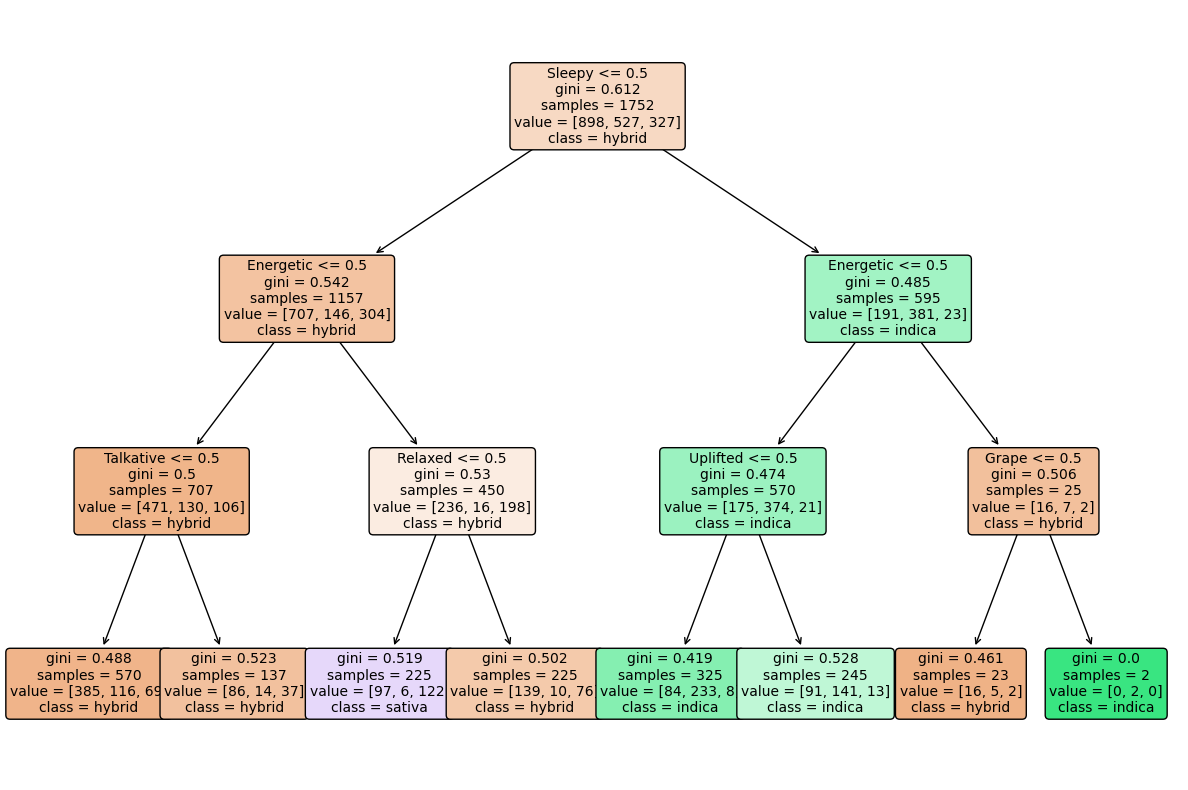

In [12]:
part2_tree = tree_model.named_steps["tree"]

plt.figure(figsize=(15,10))
plot_tree(
    part2_tree,
    feature_names=X.columns,
    class_names=label_encoder.classes_,
    filled=True,
    rounded=True,
    fontsize=10,
)
tree_matrix = confusion_matrix(y_test, tree_model.predict(X_test), labels=tree_model.named_steps["tree"].classes_)

tree_conf_matrix = pd.DataFrame(
    tree_matrix,
    index=label_encoder.classes_,
    columns=label_encoder.classes_
)
print(tree_conf_matrix)

We can see that the decision tree has 8 nodes and depth of 3. The tree looks to split on if the strain of cannabis has the effect of making you tired or not. This model has a crossvalidation accuracy of 0.6358 for prediction which type of cannabis the strand is based on the data.

## Question 2

Repeat the analyses from Part One for LDA, QDA, and KNN.

### LDA

In [13]:
lda_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])

lda_model = lda_pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(lda_model, X_train, y_train, cv=5, scoring="accuracy")

param_grid = {
    'lda__solver': ['svd', 'lsqr', 'eigen'],
    'lda__shrinkage': [None, 'auto'],
}

gscv = GridSearchCV(lda_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

gscv.fit(X_train, y_train)

best_lda = gscv.best_estimator_
lda_y_pred = best_lda.predict(X_test)

print("Best Parameters:", gscv.best_params_)

print("Best Cross-Validated Accuracy:", gscv.best_score_)
lda_conf = confusion_matrix(y_test, lda_y_pred)
lda_conf_matrix = pd.DataFrame(
    lda_conf,
    index=label_encoder.classes_,
    columns=label_encoder.classes_
)
print(lda_conf_matrix)

Best Parameters: {'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}
Best Cross-Validated Accuracy: 0.6324021164021165
        hybrid  indica  sativa
hybrid     139      42      44
indica      57      69       6
sativa      35       2      45
Best Parameters: {'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}
Best Cross-Validated Accuracy: 0.6324021164021165
        hybrid  indica  sativa
hybrid     139      42      44
indica      57      69       6
sativa      35       2      45


### QDA

In [14]:
qda_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('qda', QuadraticDiscriminantAnalysis())
])

param_grid = {
    'qda__reg_param': [0.0, 0.1, 0.2, 0.5, 1.0],
}

qda_gscv = GridSearchCV(qda_pipeline, param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
qda_gscv.fit(X_train, y_train)

print("Best Parameters:", qda_gscv.best_params_)
print("Best Cross-Validated Accuracy:", qda_gscv.best_score_)

best_qda = qda_gscv.best_estimator_
qda_y_pred = best_qda.predict(X_test)

qda_conf = confusion_matrix(y_test, qda_y_pred)
qda_conf_matrix = pd.DataFrame(
    qda_conf,
    index=label_encoder.classes_,
    columns=label_encoder.classes_
)

print(qda_conf_matrix)

Best Parameters: {'qda__reg_param': 1.0}
Best Cross-Validated Accuracy: 0.6329816849816849
        hybrid  indica  sativa
hybrid     137      43      45
indica      55      70       7
sativa      37       1      44
Best Parameters: {'qda__reg_param': 1.0}
Best Cross-Validated Accuracy: 0.6329816849816849
        hybrid  indica  sativa
hybrid     137      43      45
indica      55      70       7
sativa      37       1      44


### KNN

In [15]:
KNN_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
# Create grid for tuning
knn_params = {
    'knn__n_neighbors': range(1, 30)
}


knn_gscv = GridSearchCV(KNN_pipeline, knn_params, cv=5, scoring='accuracy')
knn_model = knn_gscv.fit(X_train, y_train)

knn_y_pred = knn_gscv.best_estimator_.predict(X_test)
print(f"Best KNN parameters: {knn_gscv.best_params_}")
print(f"KNN Accuracy: {knn_gscv.best_score_}")

knn_conf = confusion_matrix(y_test, knn_y_pred)
knn_conf_matrix = pd.DataFrame(
    knn_conf,
    index=label_encoder.classes_,
    columns=label_encoder.classes_
)

print(knn_conf_matrix)

Best KNN parameters: {'knn__n_neighbors': 22}
KNN Accuracy: 0.5861815221815222
        hybrid  indica  sativa
hybrid     182      35       8
indica      78      52       2
sativa      74       1       7
Best KNN parameters: {'knn__n_neighbors': 22}
KNN Accuracy: 0.5861815221815222
        hybrid  indica  sativa
hybrid     182      35       8
indica      78      52       2
sativa      74       1       7


### Question 3

Were your metrics better or worse than in Part One? Why? Which categories were most likely to get mixed up, according to the confusion matrices? Why?

For each of the models the accuracy rate was higher in part one than in part two. In part one, all of the models had a cross validation accuracy of around 0.83. In part two this number decreased to around 0.6. This makes intuitive sense because we are adding in another category in part two that the models have to distiguish between which makes the probability of prediciting the correct type of cannabis lower. It seems that the hybrid strains are being misclassified the most out of all three of them. This also makes some sense because hybrid is a mix of the sativa and indica types of cannabis, so they may have features that are hard to distinuish between. In part one we were only looking to classify between sativa and indica which are two unique types of cannabis, so it makes sense that the models had an easier time predicting this.

# Part Three: Multiclass from Binary

Consider two models designed for binary classification: SVC and Logistic Regression.

## Question 1

Fit and report metrics for OvR versions of the models. That is, for each of the two model types, create three models:

* Indica vs. Not Indica

* Sativa vs. Not Sativa

* Hybrid vs. Not Hybrid

In [18]:
logit_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(max_iter=1000))
])

logit_params = {'logit__C': [0.01, 0.1, 1, 10, 100]}

svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC())
])
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__max_iter': [1000, 5000],
}


In [31]:
cannabis_df = cannabis_df.copy()
cannabis_df.loc[:, "indica"] = (cannabis_df["Type"] == "indica").astype(int)

X = cannabis_df.drop(columns= ["indica", "Type"])
y = cannabis_df["indica"]

X = pd.get_dummies(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(cannabis_df['Type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, stratify=y)

svc_gscv = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='accuracy')
svc_model = svc_gscv.fit(X_train, y_train)
svc_y_pred = svc_gscv.best_estimator_.predict(X_test)
print(f"Best SVC parameters: {svc_gscv.best_params_}")
print(f"Best Accuracy: {svc_gscv.best_score_}\n")

logit_gscv = GridSearchCV(logit_pipeline, logit_params, cv=5, scoring='accuracy')
logit_model = logit_gscv.fit(X_train, y_train)
print(f"Best Logistic parameters: {logit_gscv.best_params_}")
print(f"Best Accuracy: {logit_gscv.best_score_}")

Best SVC parameters: {'svc__C': 0.1, 'svc__max_iter': 1000}
Best Accuracy: 0.8581955667580992

Best SVC parameters: {'svc__C': 0.1, 'svc__max_iter': 1000}
Best Accuracy: 0.8581955667580992



Best Logistic parameters: {'logit__C': 100}
Best Accuracy: 0.8362795611238788
Best Logistic parameters: {'logit__C': 100}
Best Accuracy: 0.8362795611238788


In [32]:
y_pred = svc_model.predict(X_test)
print(f"Metrics for SVC: Indica vs. Not Indica")
print(classification_report(y_test, y_pred))

y_pred = logit_model.predict(X_test)
print(f"Metrics for Logistic Regression: Indica vs. Not Indica")
print(classification_report(y_test, y_pred))

Metrics for SVC: Indica vs. Not Indica
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       383
           1       0.90      0.65      0.76       165

    accuracy                           0.87       548
   macro avg       0.88      0.81      0.84       548
weighted avg       0.88      0.87      0.87       548

Metrics for Logistic Regression: Indica vs. Not Indica
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       383
           1       0.90      0.52      0.66       165

    accuracy                           0.84       548
   macro avg       0.86      0.75      0.78       548
weighted avg       0.85      0.84      0.82       548

Metrics for SVC: Indica vs. Not Indica
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       383
           1       0.90      0.65      0.76       165

    accuracy                           0.87      

In [33]:
cannabis_df = cannabis_df.copy()
cannabis_df.loc[:, "sativa"] = (cannabis_df["Type"] == "sativa").astype(int)

X = cannabis_df.drop(columns= ["indica", "sativa", "Type"])
y = cannabis_df["sativa"]

X = pd.get_dummies(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(cannabis_df['Type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, stratify=y)

svc_gscv = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='accuracy')
svc_model = svc_gscv.fit(X_train, y_train)
svc_y_pred = svc_gscv.best_estimator_.predict(X_test)
print(f"Best SVC parameters: {svc_gscv.best_params_}")
print(f"Best Accuracy: {svc_gscv.best_score_}\n")

logit_gscv = GridSearchCV(logit_pipeline, logit_params, cv=5, scoring='accuracy')
logit_model = logit_gscv.fit(X_train, y_train)
print(f"Best Logistic parameters: {logit_gscv.best_params_}")
print(f"Best Accuracy: {logit_gscv.best_score_}")

Best SVC parameters: {'svc__C': 0.1, 'svc__max_iter': 1000}
Best Accuracy: 0.8417506857439395

Best SVC parameters: {'svc__C': 0.1, 'svc__max_iter': 1000}
Best Accuracy: 0.8417506857439395



Best Logistic parameters: {'logit__C': 10}
Best Accuracy: 0.8308010230558234
Best Logistic parameters: {'logit__C': 10}
Best Accuracy: 0.8308010230558234


In [34]:
y_pred = svc_model.predict(X_test)
print(f"Metrics for SVC: Sativa vs. Not Sativa")
print(classification_report(y_test, y_pred))

y_pred = logit_model.predict(X_test)
print(f"Metrics for Logistic Regression: Sativa vs. Not Sativa")
print(classification_report(y_test, y_pred))

Metrics for SVC: Sativa vs. Not Sativa
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       446
           1       0.57      0.16      0.25       102

    accuracy                           0.82       548
   macro avg       0.70      0.56      0.57       548
weighted avg       0.79      0.82      0.78       548

Metrics for Logistic Regression: Sativa vs. Not Sativa
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       446
           1       1.00      0.10      0.18       102

    accuracy                           0.83       548
   macro avg       0.91      0.55      0.54       548
weighted avg       0.86      0.83      0.77       548

Metrics for SVC: Sativa vs. Not Sativa
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       446
           1       0.57      0.16      0.25       102

    accuracy                           0.82      

In [27]:
cannabis_df = cannabis_df.copy()
cannabis_df.loc[:, "hybrid"] = (cannabis_df["Type"] == "hybrid").astype(int)

X = cannabis_df.drop(columns= ["indica", "sativa", "hybrid", "Type"])
y = cannabis_df["hybrid"]

X = pd.get_dummies(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(cannabis_df['Type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, stratify=y)

svc_gscv = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='accuracy')
svc_model = svc_gscv.fit(X_train, y_train)
svc_y_pred = svc_gscv.best_estimator_.predict(X_test)
print(f"Best SVC parameters: {svc_gscv.best_params_}")
print(f"Best Accuracy: {svc_gscv.best_score_}\n")

logit_gscv = GridSearchCV(logit_pipeline, logit_params, cv=5, scoring='accuracy')
logit_model = logit_gscv.fit(X_train, y_train)
print(f"Best Logistic parameters: {logit_gscv.best_params_}")
print(f"Best Accuracy: {logit_gscv.best_score_}")

Best SVC parameters: {'svc__C': 0.1, 'svc__max_iter': 1000}
Best Accuracy: 0.5843020238713026

Best SVC parameters: {'svc__C': 0.1, 'svc__max_iter': 1000}
Best Accuracy: 0.5843020238713026



Best Logistic parameters: {'logit__C': 0.01}
Best Accuracy: 0.5879642671806657
Best Logistic parameters: {'logit__C': 0.01}
Best Accuracy: 0.5879642671806657


In [30]:
y_pred = svc_model.predict(X_test)
print(f"Metrics for SVC: Hybrid vs. Not Hybrid")
print(classification_report(y_test, y_pred))

y_pred = logit_model.predict(X_test)
print(f"Metrics for Logistic Regression: Hybrid vs. Not Hybrid")
print(classification_report(y_test, y_pred))

Metrics for SVC: Hybrid vs. Not Hybrid
              precision    recall  f1-score   support

           0       0.58      0.51      0.54       267
           1       0.58      0.65      0.62       281

    accuracy                           0.58       548
   macro avg       0.58      0.58      0.58       548
weighted avg       0.58      0.58      0.58       548

Metrics for Logistic Regression: Hybrid vs. Not Hybrid
              precision    recall  f1-score   support

           0       0.59      0.51      0.54       267
           1       0.59      0.67      0.62       281

    accuracy                           0.59       548
   macro avg       0.59      0.59      0.58       548
weighted avg       0.59      0.59      0.58       548

Metrics for SVC: Hybrid vs. Not Hybrid
              precision    recall  f1-score   support

           0       0.58      0.51      0.54       267
           1       0.58      0.65      0.62       281

    accuracy                           0.58      

## Question 2

Which of the six models did the best job distinguishing the target category from the rest? Which did the worst? Does this make intuitive sense?

The model that had the highest accuracy was the SVC model for the indica vs not indica with an accuracy of 0.87. This makes sense because indica is unique from the other two types of cannabis, so the models have an easier path of identifying the trends that Indica strains have. The model that has the lowest accuracy is both the SVC and logistic regression models for hybrid vs not hybrid. This also make sense intuitively because the hybrid strains are likely similar to either the sativa or indica strains. The hybrids are probably much harder for the models to distinguish from the other two, leading to misclassifications.

## Question 3:

Fit and report metrics for OvO versions of the models. That is, for each of the two model types, create three models:

* Indica vs. Sativa

* Indica vs. Hybrid

* Hybrid vs. Sativa


In [35]:
cannabis_df = cannabis_df.drop(columns= ["indica", "sativa", "hybrid"])

In [38]:
indica_sativa = cannabis_df[(cannabis_df["Type"] == "indica") | (cannabis_df["Type"] == "sativa")]

X = indica_sativa.drop(columns= ["Type", "Strain","Effects","Flavor"])
y = indica_sativa["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y)

svc_gscv = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='accuracy')
svc_model = svc_gscv.fit(X_train, y_train)
svc_y_pred = svc_gscv.best_estimator_.predict(X_test)
print(f"Best SVC parameters: {svc_gscv.best_params_}")
print(f"Best Accuracy: {svc_gscv.best_score_}\n")

logit_gscv = GridSearchCV(logit_pipeline, logit_params, cv=5, scoring='f1_weighted')
logit_model = logit_gscv.fit(X_train, y_train)
print(f"Best Logistic parameters: {logit_gscv.best_params_}")
print(f"Best Accuracy: {logit_gscv.best_score_}")

Best SVC parameters: {'svc__C': 1, 'svc__max_iter': 1000}
Best Accuracy: 0.8552173913043479

Best SVC parameters: {'svc__C': 1, 'svc__max_iter': 1000}
Best Accuracy: 0.8552173913043479



Best Logistic parameters: {'logit__C': 0.1}
Best Accuracy: 0.8517784550191181
Best Logistic parameters: {'logit__C': 0.1}
Best Accuracy: 0.8517784550191181


In [39]:
y_pred = svc_model.predict(X_test)
print(f"Metrics for SVC: Indica vs. Sativa")
print(classification_report(y_test, y_pred))

y_pred = logit_model.predict(X_test)
print(f"Metrics for Logistic Regression: Indica vs. Sativa")
print(classification_report(y_test, y_pred))

Metrics for SVC: Indica vs. Sativa
              precision    recall  f1-score   support

      indica       0.91      0.90      0.91       165
      sativa       0.85      0.86      0.85       102

    accuracy                           0.89       267
   macro avg       0.88      0.88      0.88       267
weighted avg       0.89      0.89      0.89       267

Metrics for Logistic Regression: Indica vs. Sativa
              precision    recall  f1-score   support

      indica       0.92      0.91      0.91       165
      sativa       0.86      0.87      0.86       102

    accuracy                           0.90       267
   macro avg       0.89      0.89      0.89       267
weighted avg       0.90      0.90      0.90       267

Metrics for SVC: Indica vs. Sativa
              precision    recall  f1-score   support

      indica       0.91      0.90      0.91       165
      sativa       0.85      0.86      0.85       102

    accuracy                           0.89       267
   macr

In [40]:
indica_sativa = cannabis_df[(cannabis_df["Type"] == "indica") | (cannabis_df["Type"] == "hybrid")]

X = indica_sativa.drop(columns= ["Type", "Strain","Effects","Flavor"])
y = indica_sativa["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y)

svc_gscv = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='accuracy')
svc_model = svc_gscv.fit(X_train, y_train)
svc_y_pred = svc_gscv.best_estimator_.predict(X_test)
print(f"Best SVC parameters: {svc_gscv.best_params_}")
print(f"Best Accuracy: {svc_gscv.best_score_}\n")

logit_gscv = GridSearchCV(logit_pipeline, logit_params, cv=5, scoring='f1_weighted')
logit_model = logit_gscv.fit(X_train, y_train)
print(f"Best Logistic parameters: {logit_gscv.best_params_}")
print(f"Best Accuracy: {logit_gscv.best_score_}")

Best SVC parameters: {'svc__C': 10, 'svc__max_iter': 5000}
Best Accuracy: 0.7485018726591761

Best SVC parameters: {'svc__C': 10, 'svc__max_iter': 5000}
Best Accuracy: 0.7485018726591761



Best Logistic parameters: {'logit__C': 0.01}
Best Accuracy: 0.7435636165751267
Best Logistic parameters: {'logit__C': 0.01}
Best Accuracy: 0.7435636165751267


In [41]:
y_pred = svc_model.predict(X_test)
print(f"Metrics for SVC: Indica vs. Hybrid")
print(classification_report(y_test, y_pred))

y_pred = logit_model.predict(X_test)
print(f"Metrics for Logistic Regression: Indica vs. Hybrid")
print(classification_report(y_test, y_pred))

Metrics for SVC: Indica vs. Hybrid
              precision    recall  f1-score   support

      hybrid       0.82      0.85      0.83       281
      indica       0.72      0.68      0.70       165

    accuracy                           0.78       446
   macro avg       0.77      0.76      0.77       446
weighted avg       0.78      0.78      0.78       446

Metrics for Logistic Regression: Indica vs. Hybrid
              precision    recall  f1-score   support

      hybrid       0.81      0.86      0.84       281
      indica       0.74      0.65      0.69       165

    accuracy                           0.78       446
   macro avg       0.77      0.76      0.76       446
weighted avg       0.78      0.78      0.78       446

Metrics for SVC: Indica vs. Hybrid
              precision    recall  f1-score   support

      hybrid       0.82      0.85      0.83       281
      indica       0.72      0.68      0.70       165

    accuracy                           0.78       446
   macr

In [42]:
indica_sativa = cannabis_df[(cannabis_df["Type"] == "hybrid") | (cannabis_df["Type"] == "sativa")]

X = indica_sativa.drop(columns= ["Type", "Strain","Effects","Flavor"])
y = indica_sativa["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y)

svc_gscv = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='accuracy')
svc_model = svc_gscv.fit(X_train, y_train)
svc_y_pred = svc_gscv.best_estimator_.predict(X_test)
print(f"Best SVC parameters: {svc_gscv.best_params_}")
print(f"Best Accuracy: {svc_gscv.best_score_}\n")

logit_gscv = GridSearchCV(logit_pipeline, logit_params, cv=5, scoring='f1_weighted')
logit_model = logit_gscv.fit(X_train, y_train)
print(f"Best Logistic parameters: {logit_gscv.best_params_}")
print(f"Best Accuracy: {logit_gscv.best_score_}")

Best SVC parameters: {'svc__C': 0.1, 'svc__max_iter': 1000}
Best Accuracy: 0.7397569774064934

Best SVC parameters: {'svc__C': 0.1, 'svc__max_iter': 1000}
Best Accuracy: 0.7397569774064934



Best Logistic parameters: {'logit__C': 0.1}
Best Accuracy: 0.7209319823218316
Best Logistic parameters: {'logit__C': 0.1}
Best Accuracy: 0.7209319823218316


In [43]:
y_pred = svc_model.predict(X_test)
print(f"Metrics for SVC: Hybrid vs. Sativa")
print(classification_report(y_test, y_pred))

y_pred = logit_model.predict(X_test)
print(f"Metrics for Logistic Regression: Hybrid vs. Sativa")
print(classification_report(y_test, y_pred))

Metrics for SVC: Hybrid vs. Sativa
              precision    recall  f1-score   support

      hybrid       0.79      0.89      0.84       281
      sativa       0.54      0.34      0.42       102

    accuracy                           0.75       383
   macro avg       0.66      0.62      0.63       383
weighted avg       0.72      0.75      0.73       383

Metrics for Logistic Regression: Hybrid vs. Sativa
              precision    recall  f1-score   support

      hybrid       0.79      0.89      0.84       281
      sativa       0.53      0.34      0.42       102

    accuracy                           0.74       383
   macro avg       0.66      0.62      0.63       383
weighted avg       0.72      0.74      0.72       383

Metrics for SVC: Hybrid vs. Sativa
              precision    recall  f1-score   support

      hybrid       0.79      0.89      0.84       281
      sativa       0.54      0.34      0.42       102

    accuracy                           0.75       383
   macr

## Question 4:
Which of the six models did the best job distinguishing at differentiating the two groups? Which did the worst? Does this make intuitive sense?

The model that did the best at distinguishing between the two groups are the logistic and SVC model for indica vs sativa. The model that did the worst was the hybrid vs sativa logistic regression model. This makes intuitive sense as there are likely a lot more differences between indica and sativa that the models can use to classify strains. There is likley much less of a difference between hybrid and sativa types of cannabis which leads to less accuracy by the model when distinguishing between the two.

## Question 5:

Suppose you had simply input the full data, with three classes, into the LogisticRegression function. Would this have automatically taken an “OvO” approach or an “OvR” approach?

What about for SVC?

If we had input the full data with three classes into the LogisticRegression function a OvR approach would be automatically taken. This method creates a model for each class being distinguished from the other classes.

For SVC, the deafult approach is OvO, so the two types of models have different default methods.